In [21]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [22]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce GTX 1650


In [23]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')

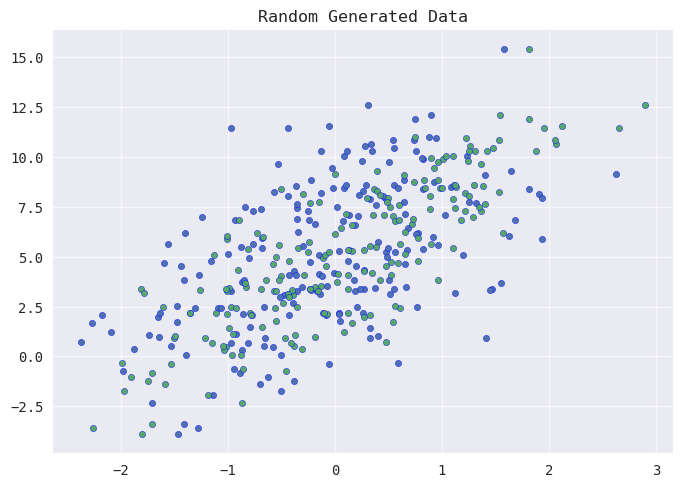

In [24]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [25]:
X, X.shape

(tensor([[-2.2633e+00,  1.6149e-01],
         [-1.7360e+00, -3.7379e-01],
         [ 1.8109e+00, -5.0295e-01],
         [-4.2864e-01,  1.2239e-01],
         [-1.4371e+00,  4.7580e-01],
         [ 8.4272e-02,  9.8218e-01],
         [ 2.7140e-01, -6.8504e-01],
         [-4.3514e-01,  2.6570e+00],
         [ 5.0478e-01,  9.6583e-01],
         [-9.2958e-03,  3.4388e-01],
         [-1.7396e-02,  8.4197e-01],
         [-5.7273e-01,  1.5286e+00],
         [ 4.7707e-01, -2.4756e-01],
         [-3.0958e-01, -1.8969e-01],
         [ 3.8829e-01,  5.9834e-01],
         [-2.4924e-01,  1.2170e+00],
         [ 8.1983e-01,  3.6981e-01],
         [-2.3630e-01, -2.3555e-01],
         [ 1.8358e-01,  1.6111e-01],
         [ 9.1939e-01, -6.6925e-01],
         [ 1.9295e+00, -1.0043e+00],
         [-1.7069e+00, -8.6737e-01],
         [-9.7228e-01,  1.9493e+00],
         [ 3.2544e-01, -1.2106e+00],
         [-8.0594e-01, -1.0796e-01],
         [ 1.2120e-01, -4.3021e-01],
         [ 1.3196e+00, -2.3428e-01],
 

In [26]:
y, y.shape

(tensor([ 1.6737,  1.0707,  8.4059,  4.0973,  4.5413,  8.4480,  3.3857, 11.4206,
          9.7481,  4.1965,  8.4530,  8.2589,  5.2097,  3.4742,  7.5972,  7.3053,
          8.4038,  3.4025,  6.5737,  5.9607,  5.8594, -2.3182, 11.4543,  0.9392,
          4.9472,  4.7621,  7.6760,  4.7733,  4.1121,  3.3743,  4.0519,  7.0506,
          5.4451,  6.6594,  1.1174,  0.9125, 10.2948,  4.6182,  5.3868,  9.6301,
          3.8454,  2.4392,  4.2974,  5.6265,  0.5025,  9.8682,  1.2283, -1.2163,
         -0.3858,  3.2905,  0.9829,  8.7622,  5.9496, 12.0831,  5.2949,  3.1023,
          3.1171,  6.1944,  3.4535,  9.9661,  2.1674,  5.1144,  0.6764, 10.9676,
          5.0721,  2.4785,  2.0724,  6.9656,  5.6024,  0.4763,  7.4816, 10.0268,
          3.3147,  0.6657, 10.6443,  2.5467,  3.4604,  3.3905,  6.0514,  3.2899,
          2.4679,  7.8802,  7.0707,  7.2646,  6.1210, 11.5258,  8.1457,  4.0628,
          6.8890,  2.5004,  2.1323,  2.0627, -0.8157,  1.9552, -0.7539, -3.5981,
          0.0863,  5.5001,  

In [27]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[-2.2633e+00,  1.6149e-01],
         [-1.7360e+00, -3.7379e-01],
         [ 1.8109e+00, -5.0295e-01],
         [-4.2864e-01,  1.2239e-01],
         [-1.4371e+00,  4.7580e-01],
         [ 8.4272e-02,  9.8218e-01],
         [ 2.7140e-01, -6.8504e-01],
         [-4.3514e-01,  2.6570e+00],
         [ 5.0478e-01,  9.6583e-01],
         [-9.2958e-03,  3.4388e-01],
         [-1.7396e-02,  8.4197e-01],
         [-5.7273e-01,  1.5286e+00],
         [ 4.7707e-01, -2.4756e-01],
         [-3.0958e-01, -1.8969e-01],
         [ 3.8829e-01,  5.9834e-01],
         [-2.4924e-01,  1.2170e+00],
         [ 8.1983e-01,  3.6981e-01],
         [-2.3630e-01, -2.3555e-01],
         [ 1.8358e-01,  1.6111e-01],
         [ 9.1939e-01, -6.6925e-01],
         [ 1.9295e+00, -1.0043e+00],
         [-1.7069e+00, -8.6737e-01],
         [-9.7228e-01,  1.9493e+00],
         [ 3.2544e-01, -1.2106e+00],
         [-8.0594e-01, -1.0796e-01],
         [ 1.2120e-01, -4.3021e-01],
         [ 1.3196e+00, -2.3428e-01],
 

In [28]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [29]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [31]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([ 1.2913, -0.4315], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.1175], device='cuda:0')
	Epoch 1 | Weights: tensor([ 1.2849, -0.3799], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.0362], device='cuda:0')
	Epoch 1 | Weights: tensor([ 1.3231, -0.3498], device='cuda:0')
	Epoch 1 | Bias: tensor([0.0513], device='cuda:0')
	Epoch 1 | Weights: tensor([ 1.3083, -0.3205], device='cuda:0')
	Epoch 1 | Bias: tensor([0.1450], device='cuda:0')
	Epoch 1 | Weights: tensor([ 1.3062, -0.3130], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2325], device='cuda:0')
Epoch 1/50 | Loss: 5.5122
	| Validation Loss: 5.1945

	Epoch 2 | Weights: tensor([ 1.3235, -0.2615], device='cuda:0')
	Epoch 2 | Bias: tensor([0.3138], device='cuda:0')
	Epoch 2 | Weights: tensor([ 1.3172, -0.2341], device='cuda:0')
	Epoch 2 | Bias: tensor([0.4013], device='cuda:0')
	Epoch 2 | Weights: tensor([ 1.2961, -0.2040], device='cuda:0')
	Epoch 2 | Bias: tensor([0.4888], device='cuda:0')
	Epoch 2 | Weights: tens

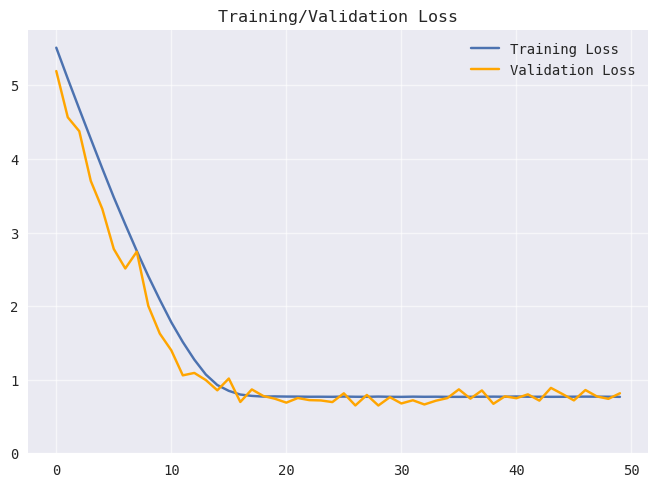

In [32]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=0)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [33]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([2.0506, 2.8580], device='cuda:0')
Trained Bias: tensor([5.0575], device='cuda:0')


In [34]:
# Analytical Solution
w = torch.linalg.inv(X.T @ X) @ X.T @ y
print(f"Analytical Solution for Weights: {w}")

Analytical Solution for Weights: tensor([1.4951, 3.3315])


In [35]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.3666, -2.3666],
        [-2.3401, -2.3401],
        [-2.3137, -2.3137],
        [-2.2873, -2.2873],
        [-2.2608, -2.2608],
        [-2.2344, -2.2344],
        [-2.2079, -2.2079],
        [-2.1815, -2.1815],
        [-2.1550, -2.1550],
        [-2.1286, -2.1286],
        [-2.1021, -2.1021],
        [-2.0757, -2.0757],
        [-2.0492, -2.0492],
        [-2.0228, -2.0228],
        [-1.9963, -1.9963],
        [-1.9699, -1.9699],
        [-1.9434, -1.9434],
        [-1.9170, -1.9170],
        [-1.8905, -1.8905],
        [-1.8641, -1.8641],
        [-1.8377, -1.8377],
        [-1.8112, -1.8112],
        [-1.7848, -1.7848],
        [-1.7583, -1.7583],
        [-1.7319, -1.7319],
        [-1.7054, -1.7054],
        [-1.6790, -1.6790],
        [-1.6525, -1.6525],
        [-1.6261, -1.6261],
        [-1.5996, -1.5996],
        [-1.5732, -1.5732],
        [-1.5467, -1.5467],
        [-1.5203, -1.5203],
        [-1.4938, -1.4938],
        [-1.4674, -1.4674],
      

In [36]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

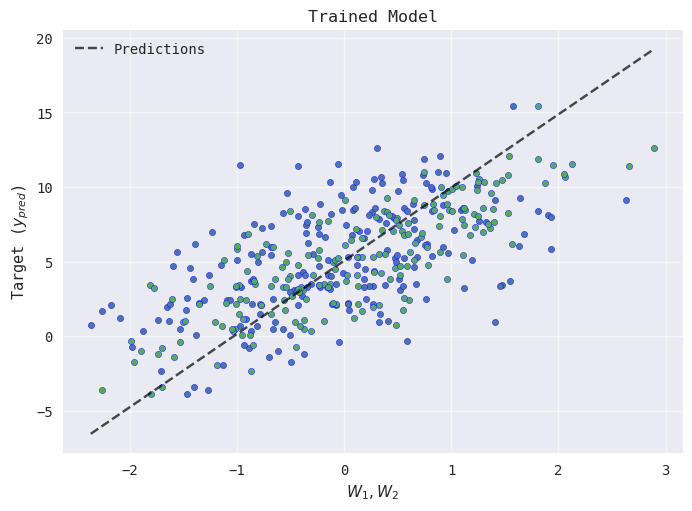

In [37]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)");
plt.legend(loc='best');
plt.show()